HR files count: 800
x2 files count: 800
x4 files count: 800
Common files count: 800
Displaying images for file prefix: 0667


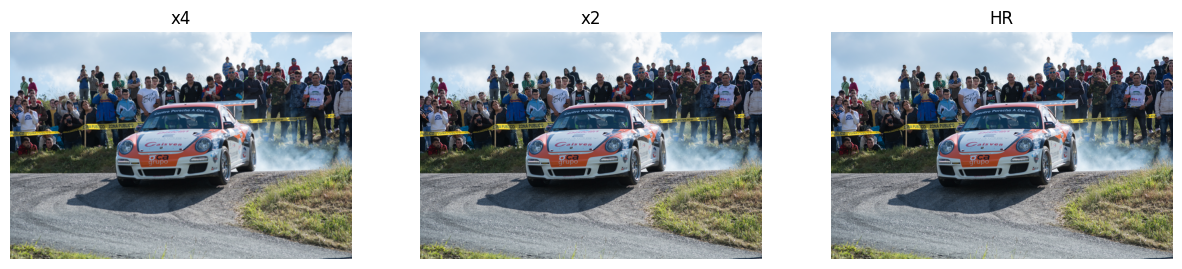

Displaying images for file prefix: 0597


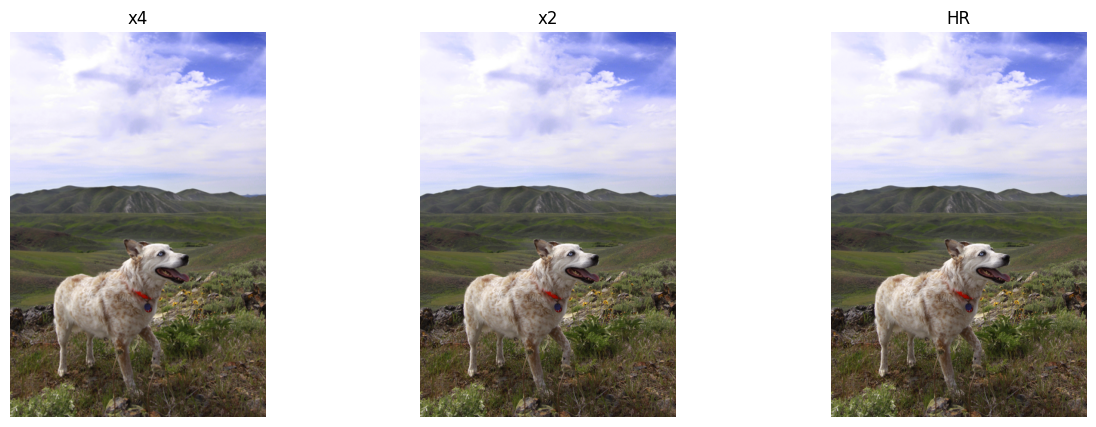

In [52]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)


#paths to the HR, x2, and x4 folders
hr_path = r"DIV2K_train_HR\DIV2K_train_HR"
x2_path = r"DIV2K_train_LR_bicubic_X2\DIV2K_train_LR_bicubic\X2"
x4_path = r"DIV2K_train_LR_bicubic_X4\DIV2K_train_LR_bicubic\X4"

hr_files = os.listdir(hr_path)
x2_files = os.listdir(x2_path)
x4_files = os.listdir(x4_path)

# file matching by the first 4 characters of filenames
hr_files_set = {f[:4] for f in hr_files}
x2_files_set = {f[:4] for f in x2_files}
x4_files_set = {f[:4] for f in x4_files}

#common files across all three folders
common_files = list(hr_files_set & x2_files_set & x4_files_set)

print(f"HR files count: {len(hr_files_set)}")
print(f"x2 files count: {len(x2_files_set)}")
print(f"x4 files count: {len(x4_files_set)}")
print(f"Common files count: {len(common_files)}")

if len(common_files) < 2:
    raise ValueError("Not enough common files to sample from. Ensure the folders have matching files.")

# Pick 2 random files from the common set
random_files = random.sample(common_files, 2)

def display_images(file_prefix):

    print(f"Displaying images for file prefix: {file_prefix}")
    hr_image = Image.open(os.path.join(hr_path, file_prefix + ".png"))
    x2_image = Image.open(os.path.join(x2_path, file_prefix + "x2.png"))
    x4_image = Image.open(os.path.join(x4_path, file_prefix + "x4.png"))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(x4_image)
    axes[0].set_title("x4")
    axes[0].axis("off")

    axes[1].imshow(x2_image)
    axes[1].set_title("x2")
    axes[1].axis("off")

    axes[2].imshow(hr_image)
    axes[2].set_title("HR")
    axes[2].axis("off")

    plt.show()

for file_prefix in random_files:
    display_images(file_prefix)

In [53]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

random.seed(42)

class DIV2KDataset(Dataset):
    def __init__(self, hr_path, x2_path, x4_path, transform=None):
        self.hr_path = hr_path
        self.x2_path = x2_path
        self.x4_path = x4_path
        self.transform = transform

        hr_files = os.listdir(hr_path)
        x2_files = os.listdir(x2_path)
        x4_files = os.listdir(x4_path)

        hr_files_set = {f[:4] for f in hr_files}
        x2_files_set = {f[:4] for f in x2_files}
        x4_files_set = {f[:4] for f in x4_files}

        self.common_files = list(hr_files_set & x2_files_set & x4_files_set)
        
        if not self.common_files:
            raise ValueError("No matching files found between HR, x2, and x4 folders.")

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        file_prefix = self.common_files[idx]

        # Load images
        hr_image = Image.open(os.path.join(self.hr_path, file_prefix + ".png"))
        x2_image = Image.open(os.path.join(self.x2_path, file_prefix + "x2.png"))
        x4_image = Image.open(os.path.join(self.x4_path, file_prefix + "x4.png"))

        # Apply transformations if any
        if self.transform:
            hr_image = self.transform(hr_image)
            x2_image = self.transform(x2_image)
            x4_image = self.transform(x4_image)

        return {
            "HR": hr_image,
            "x2": x2_image,
            "x4": x4_image,
            "filename": file_prefix
        }
    
transformer = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(), 
])

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
#I had to set the num of workers to zero because I was getting an error about GPU memory..

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8
dataset = DIV2KDataset(hr_path, x2_path, x4_path, transform=transformer)

#train and test sets
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, 
                                               test_size=0.15, 
                                               random_state=42)

# Create subset datasets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Define DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=0)


In [56]:
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")
print(f'Number of train batches: {len(train_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of training samples: 680
Number of testing samples: 120
Number of train batches: 85
Number of test batches: 15


In [57]:
batch = next(iter(train_loader))

print(f"Batch keys: {batch.keys()}")
print(f"HR Image batch shape: {batch['HR'].shape}")
print(f"x2 Image batch shape: {batch['x2'].shape}")
print(f"x4 Image batch shape: {batch['x4'].shape}")
print(f"Filenames in batch: {batch['filename']}")

Batch keys: dict_keys(['HR', 'x2', 'x4', 'filename'])
HR Image batch shape: torch.Size([8, 3, 224, 224])
x2 Image batch shape: torch.Size([8, 3, 224, 224])
x4 Image batch shape: torch.Size([8, 3, 224, 224])
Filenames in batch: ['0302', '0432', '0754', '0273', '0634', '0321', '0537', '0060']


In [58]:
import torch.nn as nn
import tqdm
from torchsummary import summary

random.seed(42)

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(inplace=True)
    )

class SingleBranchSuperResolutionNet(nn.Module):
    def __init__(self):
        super(SingleBranchSuperResolutionNet, self).__init__()

        # Feature extraction
        self.feature_extraction = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64),
            conv_block(64, 64)
        )

        # Non-linear Mapping
        self.mapping = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64)
        )

        # Upsampling Layer (factor of 2)
        self.upsampling = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),  # Upsample by a factor of 2
            nn.ReLU(inplace=True)
        )

        # Reconstruction Layer
        self.reconstruction = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(224, 224), mode="bilinear", align_corners=False)  # Ensure output size is 224x224
        )

    def forward(self, x):
        # Feature extraction
        features = self.feature_extraction(x)

        # Non-linear mapping
        mapped_features = self.mapping(features)

        # Upsampling
        upsampled_features = self.upsampling(mapped_features)

        # Reconstruction (ensure final output is 224x224)
        residual = self.reconstruction(upsampled_features)

        # Add residual to the input (residual connection)
        hr_image = x + residual

        return hr_image

In [59]:
model = SingleBranchSuperResolutionNet().to(device)
print(model)

SingleBranchSuperResolutionNet(
  (feature_extraction): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (mapping): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (upsampling): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [60]:
x4_dummy = torch.randn(1, 3, 224, 224).to(device)  # Dummy input for x4 
summary(model, (3, 224, 224))

output = model(x4_dummy)
print("Output shape:", output.shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
              ReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          36,928
             ReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]          36,928
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13        [-1, 256, 224, 224]         147,712
     PixelShuffle-14         [-1, 64, 4

In [61]:
from tqdm import tqdm
# Train step function
def train_step(model, dataloader, loss_fn, optimizer, device, gradient_clip_value=None):
    model.train()
    train_loss = 0.0
    
    loop = tqdm(dataloader, desc="Training", leave=True)
    for batch in loop:
        inputs, targets = batch["x4"].to(device), batch["HR"].to(device)

        # Forward pass
        predictions = model(inputs)

        # Compute loss
        loss = loss_fn(predictions, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        if gradient_clip_value is not None:
            nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)

        optimizer.step()

        loop.set_postfix(loss=loss.item())

    return train_loss / len(dataloader)

In [62]:
# Test step function
from pytorch_msssim import ssim
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    psnr_total, ssim_total = 0.0, 0.0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Testing", leave=True)
        for batch in loop:
            inputs, targets = batch["x4"].to(device), batch["HR"].to(device)

            # Forward pass
            predictions = model(inputs)

            # Compute loss
            loss = loss_fn(predictions, targets)
            test_loss += loss.item()

            # Compute PSNR
            mse = torch.mean((predictions - targets) ** 2)
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))  # Assuming normalized [0, 1]
            psnr_total += psnr.item()

            # Compute SSIM
            ssim_value = ssim(predictions, targets, data_range=1.0)
            ssim_total += ssim_value.item()

            # Update tqdm description
            loop.set_postfix(loss=loss.item(), psnr=psnr.item(), ssim=ssim_value.item())

    avg_psnr = psnr_total / len(dataloader)
    avg_ssim = ssim_total / len(dataloader)
    return test_loss / len(dataloader), avg_psnr, avg_ssim

In [63]:
# Train function
def train(model, train_loader, test_loader, loss_fn, optimizer, epochs, device, gradient_clip_value=None):
    psnr_values = []
    ssim_values = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train step
        train_loss = train_step(model, train_loader, loss_fn, optimizer, device, gradient_clip_value)
        print(f"Train Loss: {train_loss:.4f}")

        # Test step
        test_loss, avg_psnr, avg_ssim = test_step(model, test_loader, loss_fn, device)
        print(f"Test Loss: {test_loss:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

        # Save metrics for plotting
        psnr_values.append(avg_psnr)
        ssim_values.append(avg_ssim)

    return psnr_values, ssim_values


In [65]:
model = SingleBranchSuperResolutionNet().to(device)

train_loader = train_loader
test_loader = test_loader   
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

psnr_values, ssim_values = train(model, train_loader, test_loader, loss_fn, optimizer, epochs=12, device=device, gradient_clip_value=1.0)

Epoch 1/12


Training: 100%|██████████| 85/85 [01:40<00:00,  1.18s/it, loss=1.31e-5] 


Train Loss: 0.0001


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.42e-5, psnr=48.5, ssim=0.998]


Test Loss: 0.0000, PSNR: 48.8161, SSIM: 0.9984
Epoch 2/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.12e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.41e-5, psnr=48.5, ssim=0.998]


Test Loss: 0.0000, PSNR: 48.8492, SSIM: 0.9984
Epoch 3/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.07e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.4e-5, psnr=48.6, ssim=0.998] 


Test Loss: 0.0000, PSNR: 48.8940, SSIM: 0.9984
Epoch 4/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.01e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.38e-5, psnr=48.6, ssim=0.998]


Test Loss: 0.0000, PSNR: 48.9553, SSIM: 0.9984
Epoch 5/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.25e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s, loss=1.36e-5, psnr=48.7, ssim=0.998]


Test Loss: 0.0000, PSNR: 49.0182, SSIM: 0.9984
Epoch 6/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.35e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.3e-5, psnr=48.9, ssim=0.999] 


Test Loss: 0.0000, PSNR: 49.1702, SSIM: 0.9984
Epoch 7/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.09e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.24e-5, psnr=49.1, ssim=0.999]


Test Loss: 0.0000, PSNR: 49.3091, SSIM: 0.9985
Epoch 8/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=9.32e-6]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.21e-5, psnr=49.2, ssim=0.999]


Test Loss: 0.0000, PSNR: 49.3932, SSIM: 0.9985
Epoch 9/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.2e-5] 


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.19e-5, psnr=49.2, ssim=0.999]


Test Loss: 0.0000, PSNR: 49.4676, SSIM: 0.9985
Epoch 10/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.16e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.19e-5, psnr=49.3, ssim=0.999]


Test Loss: 0.0000, PSNR: 49.5009, SSIM: 0.9985
Epoch 11/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.28e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.18e-5, psnr=49.3, ssim=0.999]


Test Loss: 0.0000, PSNR: 49.5246, SSIM: 0.9985
Epoch 12/12


Training: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, loss=1.45e-5]


Train Loss: 0.0000


Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, loss=1.17e-5, psnr=49.3, ssim=0.999]

Test Loss: 0.0000, PSNR: 49.5527, SSIM: 0.9985


In [68]:
# Plotting PSNR
def plot_psnr(psnr_values):
    if len(psnr_values) == 0:
        print("PSNR values are empty. Ensure training ran properly.")
        return

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(psnr_values) + 1), psnr_values, label="PSNR", linestyle='-', color='blue')
    plt.xticks(range(1, len(psnr_values) + 1))  # Ensure x-axis corresponds to epochs
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.title("PSNR over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()



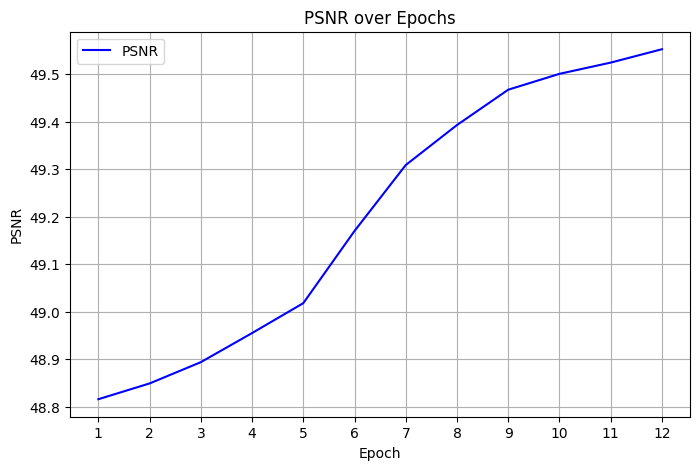

In [69]:
# Plot PSNR
plot_psnr(psnr_values)